# Ch.16 - Logistic Regression

In [1]:
from collections import Counter
from functools import partial, reduce
from linear_algebra import dot, vector_add
from gradient_descent import maximize_stochastic, maximize_batch
from working_with_data import rescale
from machine_learning import train_test_split
from multiple_regression import estimate_beta, predict

import math, random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

def logistic_prime(x):
    return logistic(x) * (1 - logistic(x))

def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i == 1:
        return math.log(logistic(dot(x_i, beta)))
    else:
        return math.log(1 - logistic(dot(x_i, beta)))

def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta)
               for x_i, y_i in zip(x, y))

def logistic_log_partial_ij(x_i, y_i, beta, j):
    """here i is the index of the data point,
    j the index of the derivative"""

    return (y_i - logistic(dot(x_i, beta))) * x_i[j]

def logistic_log_gradient_i(x_i, y_i, beta):
    """the gradient of the log likelihood
    corresponding to the i-th data point"""

    return [logistic_log_partial_ij(x_i, y_i, beta, j)
            for j, _ in enumerate(beta)]

def logistic_log_gradient(x, y, beta):
    return reduce(vector_add,
                  [logistic_log_gradient_i(x_i, y_i, beta)
                   for x_i, y_i in zip(x,y)])

In [3]:
# [experience, salary, paid_account]
data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),(6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),(0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),(9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),(4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),(5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),(9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),(0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),(7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),(4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),(2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),(2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),(7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),(2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),(8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),(7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),(2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),(5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),(8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),(1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),(9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),(2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),(7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),(6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),(0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),(9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),(2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),(6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),(4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),(4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),(9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),(2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),(4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),(7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),(6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),(9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),(6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),(0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),(2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),(6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]
data = list(map(list, data)) # change tuples to lists

x = [[1] + row[:2] for row in data] # each element is [1, experience, salary]
y = [row[2] for row in data]        # each element is paid_account

$paid acount = \beta_0+\beta_1 experience+\beta_2 salary+\epsilon$

In [4]:
unpaid_salaries = [row[0] for row in data if row[2] == 0]
unpaid_users = [row[1] for row in data if row[2] == 0]
paid_salaries = [row[0] for row in data if row[2] == 1]
paid_users = [row[1] for row in data if row[2] == 1]

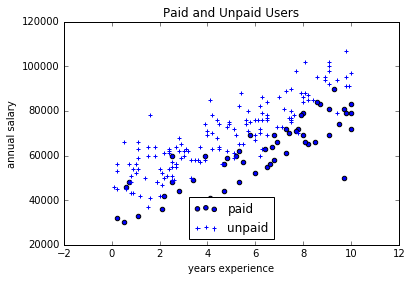

In [5]:
plt.scatter(paid_salaries, paid_users, marker='o', label='paid')
plt.scatter(unpaid_salaries, unpaid_users, marker='+', label='unpaid')
plt.title("Paid and Unpaid Users")
plt.xlabel("years experience")
plt.ylabel("annual salary")
plt.legend(loc=8)
plt.show()

In [6]:
print("linear regression:")

rescaled_x = rescale(x)
beta = estimate_beta(rescaled_x, y)  # [0.26, 0.43, -0.43]
print(beta)

linear regression:
[0.25990975738309924, 0.4387570870053767, -0.4274411364799935]


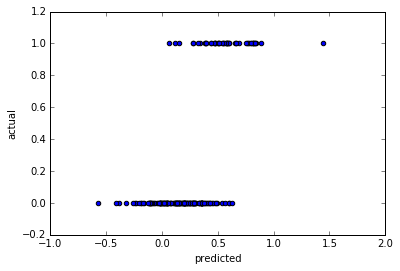

In [7]:
predictions = [predict(x_i, beta) for x_i in rescaled_x]

plt.scatter(predictions, y)
plt.xlabel("predicted")
plt.ylabel("actual")
plt.show()

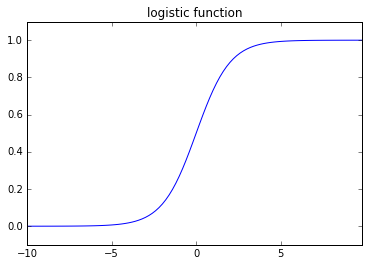

In [8]:
sig_x = np.arange(-10., 10., 0.2)
sig_y = [logistic(_) for _ in sig_x]
plt.plot(sig_x, sig_y)
plt.margins(0, 0.1)
plt.title("logistic function")
plt.show()

$
logistic(x) = \frac{1.0} {1+e^-x}\\
p(y_i|x_i\beta) = f(x_i\beta)^{y_i}(1-f(x_i\beta))^{1-y_i} \\
log L(\beta|x_iy_i) = y_i log f(x_i\beta) + (1 - y_i) log(1 - f(x_i\beta))
$

In [9]:
print("logistic regression:")

random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)

# want to maximize log likelihood on the training data
fn = partial(logistic_log_likelihood, x_train, y_train)
gradient_fn = partial(logistic_log_gradient, x_train, y_train)

# pick a random starting point
beta_0 = [1, 1, 1]
# beta_0 = [random.random() for _ in range(3)]

# and maximize using gradient descent
beta_hat = maximize_batch(fn, gradient_fn, beta_0)

print("beta_batch", beta_hat)

# beta_0 = [1, 1, 1]
beta_hat = maximize_stochastic(logistic_log_likelihood_i,
                               logistic_log_gradient_i,
                               x_train, y_train, beta_0)

print("beta stochastic", beta_hat)

logistic regression:
beta_batch [-1.906182482651773, 4.053083869373743, -3.8788953691426906]
beta stochastic [-1.9033596650613738, 4.048485018705759, -3.8747571420402442]


### Confusion Matrix
$Accuracy(정확도) = \frac{TP+TN} {TP+TN+FN+FP} \\
Precision(정밀도) = \frac{TP} {TP+FP} \\
Recall(재현율) = \frac{TP} {TP+FN} \\
F1 Score = \frac{2 * Recall * Precision} {Recall + Precision}$

In [10]:
true_positives = true_negatives = false_positives = false_negatives = 0

for x_i, y_i in zip(x_test, y_test):
    predict = logistic(dot(beta_hat, x_i))

    if y_i == 1 and predict >= 0.5:    # TP: paid and we predict paid
        true_positives += 1
    elif y_i == 1:                     # FN: paid and we predict unpaid
        false_negatives += 1
    elif y_i == 0 and predict >= 0.5:  # FP: unpaid and we predict paid
        false_positives += 1
    else:                              # TN: unpaid and we predict unpaid
        true_negatives += 1
        
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

print("precision", precision)
print("recall", recall)

precision 0.9333333333333333
recall 0.8235294117647058


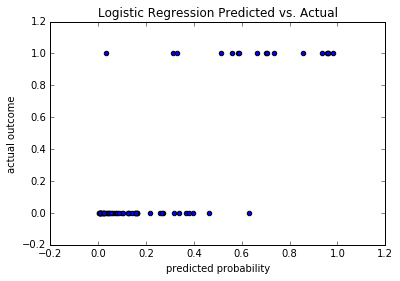

In [11]:
predictions = [logistic(dot(beta_hat, x_i)) for x_i in x_test]
plt.scatter(predictions, y_test)
plt.xlabel("predicted probability")
plt.ylabel("actual outcome")
plt.title("Logistic Regression Predicted vs. Actual")
plt.show()

### Decision Boundary
https://www.coursera.org/learn/machine-learning/lecture/WuL1H/decision-boundary

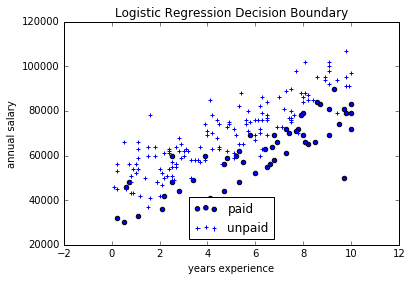

In [12]:
plt.scatter(paid_salaries, paid_users, marker='o', label='paid')
plt.scatter(unpaid_salaries, unpaid_users, marker='+', label='unpaid')
plt.title("Logistic Regression Decision Boundary")
plt.xlabel("years experience")
plt.ylabel("annual salary")
plt.legend(loc=8)
plt.show()